<a href="https://colab.research.google.com/github/Elman295/binary_alpha_digits/blob/main/binary_alpha_digits_Slow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1404 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/binary_alpha_digits/1.0.0.incompleteYZ3AUC/binary_alpha_digits-train.tfrecord*…

Dataset binary_alpha_digits downloaded and prepared to ~/tensorflow_datasets/binary_alpha_digits/1.0.0. Subsequent calls will reuse this data.


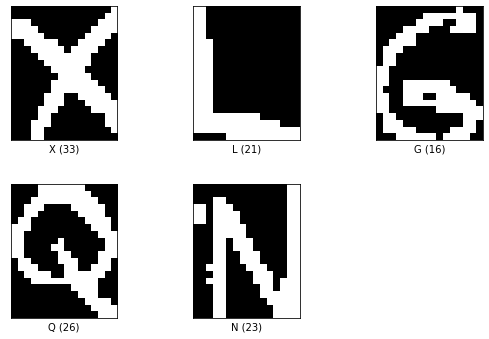

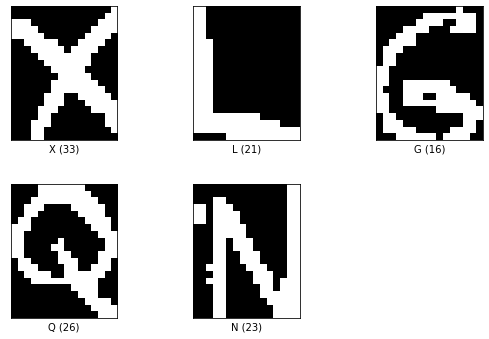

In [2]:
data, info = tfds.load("binary_alpha_digits", split = "train", with_info=True)
samples = data.take(5)
tfds.show_examples(samples, info)

In [3]:
x_train, y_train =tfds.as_numpy(tfds.load("binary_alpha_digits", split = "train[:80%]", batch_size=-1, as_supervised=True))
x_test, y_test = tfds.as_numpy(tfds.load("binary_alpha_digits", split = "train[80%:]", batch_size=-1, as_supervised=True))
print(f" x_train shape is :  {x_train.shape}")
print(f" x_test shape is :  {x_test.shape}")
print(f" y_train shape is :  {y_train.shape}")
print(f" y_test shape is :  {y_test.shape}")

 x_train shape is :  (1123, 20, 16, 1)
 x_test shape is :  (281, 20, 16, 1)
 y_train shape is :  (1123,)
 y_test shape is :  (281,)


In [4]:
x_train, x_test = x_train/255.0, x_test/255.0

# x_train = x_train[..., tf.newaxis].astype("float32")
# x_test = x_test[..., tf.newaxis].astype("float32")
x_train = x_train.reshape(1123,20,16,1)
x_test = x_test.reshape(281,20,16,1)
print(x_train.shape)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

(1123, 20, 16, 1)


# `Creating the model`

In [5]:
class Model(tf.keras.Model):

  def __init__(self):
    super(Model,self).__init__()
    self.conv_11 = tf.keras.layers.Conv2D(filters = 32, padding="same", kernel_size=(3,3), activation = "relu")
    self.conv_12 = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation= "relu")
    self.pool_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.drop = tf.keras.layers.Dropout(0.2)

    self.conv_21 = tf.keras.layers.Conv2D(filters = 64, padding="same", kernel_size=(3,3), activation = "relu")
    self.conv_22 = tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3), activation="relu")
    self.pool_2 = tf.keras.layers.MaxPool2D(pool_size = (2,2))

    self.flatten = tf.keras.layers.Flatten()
    self.dense_1 = tf.keras.layers.Dense(units = 250, activation="relu")
    self.dense_2 = tf.keras.layers.Dense(units = 36)


  def call(self, x):
    x = self.conv_11(x)
    x = self.conv_12(x)
    x = self.pool_1(x)
    x = self.drop(x)
    x = self.conv_21(x)
    x = self.conv_22(x)
    x = self.pool_2(x)
    x = self.drop(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    return self.dense_2(x)


model = Model()


In [6]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [7]:
train_accuracy = tf.keras.metrics.SparseTopKCategoricalAccuracy(name = "train_accuracy")
test_accuracy = tf.keras.metrics.SparseTopKCategoricalAccuracy(name = "test_accuracy")

train_loss = tf.keras.metrics.Mean(name = "train_loss")
test_loss = tf.keras.metrics.Mean(name = "test_loss")

# `Training the model`

In [8]:
@tf.function
def train_model(images, labels):
  with tf.GradientTape() as tape:
    prediction = model(images, training = True)
    loss = loss_object(labels, prediction)
  gradient = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradient, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, prediction)

# `Testing the model`

In [9]:
@tf.function
def test_model(images, labels):
  prediction = model(images, training = False)
  loss = loss_object(labels, prediction)

  test_loss(loss)
  test_accuracy(labels, prediction)

# `Fitting the model`

In [10]:
EPOCHS = 20 

for epochs in range(EPOCHS):
  train_accuracy.reset_states()
  test_accuracy.reset_states()
  train_loss.reset_states()
  test_loss.reset_states()

  for images, labels in train_ds:
    train_model(images, labels)

  for images, labels in test_ds:
    test_model(images, labels)

  print(f"epochs : {epochs + 1} \n train_accuracy : {train_accuracy.result()} \n test_accuracy : {test_accuracy.result()} \n train_loss : {train_loss.result()} \n test_loss : {test_loss.result()}")
    

epochs : 1 
 train_accuracy : 0.11487088352441788 
 test_accuracy : 0.08185053616762161 
 train_loss : 3.585038900375366 
 test_loss : 3.586043119430542
epochs : 2 
 train_accuracy : 0.14603739976882935 
 test_accuracy : 0.08185053616762161 
 train_loss : 3.5834994316101074 
 test_loss : 3.5886569023132324
epochs : 3 
 train_accuracy : 0.14781834185123444 
 test_accuracy : 0.0854092538356781 
 train_loss : 3.583125591278076 
 test_loss : 3.5904338359832764
epochs : 4 
 train_accuracy : 0.14959928393363953 
 test_accuracy : 0.07473309338092804 
 train_loss : 3.5829946994781494 
 test_loss : 3.593661069869995
epochs : 5 
 train_accuracy : 0.14870882034301758 
 test_accuracy : 0.07473309338092804 
 train_loss : 3.5820436477661133 
 test_loss : 3.59610915184021
epochs : 6 
 train_accuracy : 0.14959928393363953 
 test_accuracy : 0.07117437571287155 
 train_loss : 3.5815603733062744 
 test_loss : 3.597513437271118
epochs : 7 
 train_accuracy : 0.15227070450782776 
 test_accuracy : 0.07473309